In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.metrics import make_scorer

In [59]:
%run utilities.py

# Load and scale the data

In [3]:
np.random.seed(3)

In [4]:
x, y = load_matlab_data('hwkdataNEW.mat')

In [5]:
xtr, ytr, xts, yts, xv, yv = train_test_val_split(x, y)

In [6]:
column_names = [
    'Age', 'Weight', 'Height', 'Adiposity Index',
    'Neck Circumference', 'Chest Circumference',
    'Ab Circumference', 'Hip Circumference',
    'Thigh Circumference', 'Knee Circumference',
    'Ankle Circumference', 'Extended Bicep Circumference',
    'Forearm  Circumference', 'Wrist Circumference'
]

In [7]:
scaler = StandardScaler()
scaler.fit(xtr)

StandardScaler(copy=True, with_mean=True, with_std=True)

# Transform the data into PCA space

In [8]:
xtr_scaled = scaler.transform(xtr)
pca = PCA()
xtr_scaled_pca = pca.fit_transform(xtr_scaled)

In [9]:
pca_pipeline = Pipeline(
    memory=None,
    steps=[
        ('scale', StandardScaler()),
        ('pca', PCA()),
    ]
)
pca_pipeline.fit(xtr)

Pipeline(memory=None,
     steps=[('scale', StandardScaler(copy=True, with_mean=True, with_std=True)), ('pca', PCA(copy=True, iterated_power='auto', n_components=None, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False))])

# Analyze the PCA

## How much variance does each loading capture?

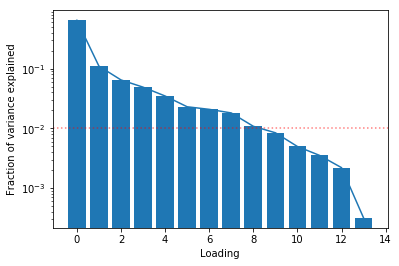

In [73]:
evr = pca_pipeline.named_steps['pca'].explained_variance_ratio_
plt.plot(pca_pipeline.named_steps['pca'].explained_variance_ratio_)
plt.bar(range(len(evr)), evr)
plt.axhline(y=0.01, linestyle=':', color='r', alpha=0.5)
plt.xlabel("Loading")
plt.ylabel("Fraction of variance explained")
plt.yscale('log')
plt.show()

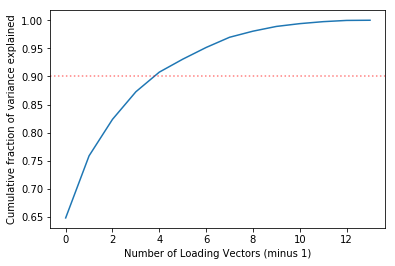

In [55]:
cum_evr = np.cumsum(pca_pipeline.named_steps['pca'].explained_variance_ratio_)
plt.plot(cum_evr)
plt.xlabel("Number of Loading Vectors (minus 1)")
plt.ylabel("Cumulative fraction of variance explained")
plt.axhline(y=0.9, linestyle=':', color='r', alpha=0.5)
plt.show()

In [53]:
np.where(cum_evr < 0.9)

(array([0, 1, 2, 3]),)

In [54]:
cum_evr[4]

0.9077686974842645

## How correlated is each loading to Body Fat Percentage?

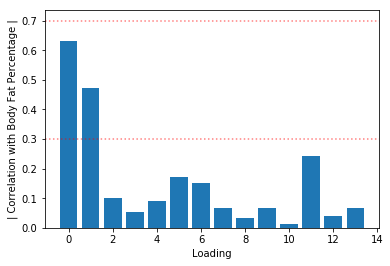

In [52]:
corr_vec = np.corrcoef(x=xtr_scaled_pca, y=ytr, rowvar=False)[-1, :-1]
plt.bar(x=range(len(corr_vec)), height=np.abs(corr_vec))
plt.xlabel('Loading')
plt.ylabel('| Correlation with Body Fat Percentage |')
plt.axhline(y=0.7, linestyle=':', color='r', alpha=0.5)
plt.axhline(y=0.3, linestyle=':', color='r', alpha=0.5)
plt.show()

## What are the first few PCA loadings comprised of?

In [36]:
pca_data = pca_pipeline.named_steps['pca']

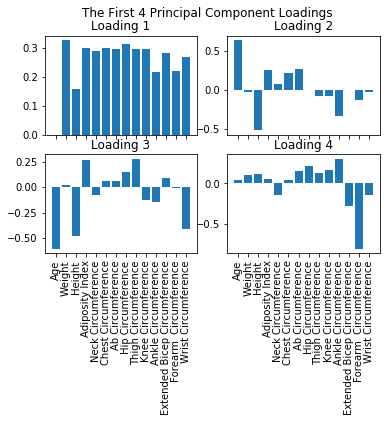

In [51]:
f, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, sharex='col')
plt.setp(ax3.xaxis.get_majorticklabels(), rotation=90)
ax1.bar(x=column_names, height=pca_data.components_[0])
ax1.set_title('Loading 1')
ax2.bar(x=column_names, height=pca_data.components_[1])
ax2.set_title('Loading 2')
ax3.bar(x=column_names, height=pca_data.components_[2])
plt.xticks(rotation=90)
ax3.set_title('Loading 3')
ax4.bar(x=column_names, height=pca_data.components_[3])
plt.xticks(rotation=90)
ax4.set_title('Loading 4')
plt.suptitle("The First 4 Principal Component Loadings")
plt.show()

## Conclusions

The data are approximately 2-3 dimensional based on two loadings that explain greater than 1% of the variance each. A total of 90% of the variance is explained by the first 5 loadings. The first loading consists of all of the measured input variables except age. 

# PCA Regression

## PCR capturing 90% of the variation in the input space

In [63]:
pcr_90_percent = LinearRegression()
pcr_90_percent.fit(xtr_scaled_pca[:,:5], ytr)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
         normalize=False)

`pca_pipeline.transform(x)` applies the same scaling and PCA transformation determined from the training set to `x` (in this case, the test data).

In [81]:
xts_scaled_pca = pca_pipeline.transform(xts)

In [66]:
pcr_90_percent_performance = rmse(pcr_90_percent.predict(xts_scaled_pca[:,:5]), yts)
print(pcr_90_percent_performance)

5.025354123263135


## PCR consisting of all loadings with >1% of variance

To pick the correct PC's based on fraction of variance they capture, we compare their eigenvalues (normalized to the sum of all of the eigenvalues). This is equivalent to the fraction of variance they explain.

In [78]:
pcr_gt10_percent = LinearRegression()
pcr_gt10_percent.fit(xtr_scaled_pca[:,:9], ytr)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
         normalize=False)

In [79]:
pcr_gt10_percent_performance = rmse(pcr_gt10_percent.predict(xts_scaled_pca[:,:9]), yts)
print(pcr_gt10_percent_performance)

4.500349403760107


## PC's most useful for predicting percent body fat

This was equivalent to including PC's that are correlated with body fat (>0.3), and consisted of only the first 2 loadings. To explore this further, I will include the next most correlated PC (index 11).

In [70]:
pcr_correlated = LinearRegression()
pcr_correlated.fit(xtr_scaled_pca[:, [0, 1, 11]], ytr)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
         normalize=False)

In [71]:
pcr_correlated_performance = rmse(pcr_correlated.predict(xts_scaled_pca[:, [0, 1, 11]]), yts)
print(pcr_correlated_performance)

4.235353993977762


In [83]:
pcr_correlated2 = LinearRegression()
pcr_correlated2.fit(xtr_scaled_pca[:, [0, 1]], ytr)
pcr_correlated2_performance = rmse(pcr_correlated2.predict(xts_scaled_pca[:, [0, 1]]), yts)
print(pcr_correlated2_performance)

4.916291312494971


## All the PCA's

In [80]:
pcr_all = LinearRegression()
pcr_all.fit(xtr_scaled_pca, ytr)
pcr_all_performance = rmse(pcr_all.predict(xts_scaled_pca), yts)
print(pcr_all_performance)

3.83265877750213


# Comparison of PCR performance

In [95]:
models = {
    'Model': [
        'PCR Capturing 90% of Variance',
        'PCR of loadings with >1% of Variance',
        'PCR of correlated loadings (>0.3)',
        'PCR of correlated loadings (>0.2)',
        'PCR of all loadings'
    ],
    'RMSE': [
        pcr_90_percent_performance,
        pcr_gt10_percent_performance,
        pcr_correlated_performance,
        pcr_correlated2_performance,
        pcr_all_performance
    ]
}

In [96]:
test_results = pd.DataFrame(models)
test_results

,Model,RMSE
0,PCR Capturing 90% of Variance,5.025354
1,PCR of loadings with >1% of Variance,4.500349
2,PCR of correlated loadings (>0.3),4.235354
3,PCR of correlated loadings (>0.2),4.916291
4,PCR of all loadings,3.832659


In [101]:
print(test_results.to_latex(index=False))

\begin{tabular}{lr}
\toprule
                                Model &      RMSE \\
\midrule
        PCR Capturing 90\% of Variance &  5.025354 \\
 PCR of loadings with >1\% of Variance &  4.500349 \\
    PCR of correlated loadings (>0.3) &  4.235354 \\
    PCR of correlated loadings (>0.2) &  4.916291 \\
                  PCR of all loadings &  3.832659 \\
\bottomrule
\end{tabular}

